# Paramagnetic Relaxation Enhancement: Dipolar Relaxation

In this example, we'll investigate the relaxation induced by presence of an anisotropic (dipolar) hyperfine coupling. We'll start with a 4-site tetrahedral exchange to mimic tumbling

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%matplotlib notebook

In [21]:
ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],LF=True,pwdavg=RS.PowderAvg(PwdType='alpha0beta0'),n_gamma=1))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-1000,Ayy=-1000,Azz=2000)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-1000,Ayy=-1000,Azz=2000,euler=[0,phi_tetra,k*2*np.pi/3])

<IPython.core.display.Javascript object>


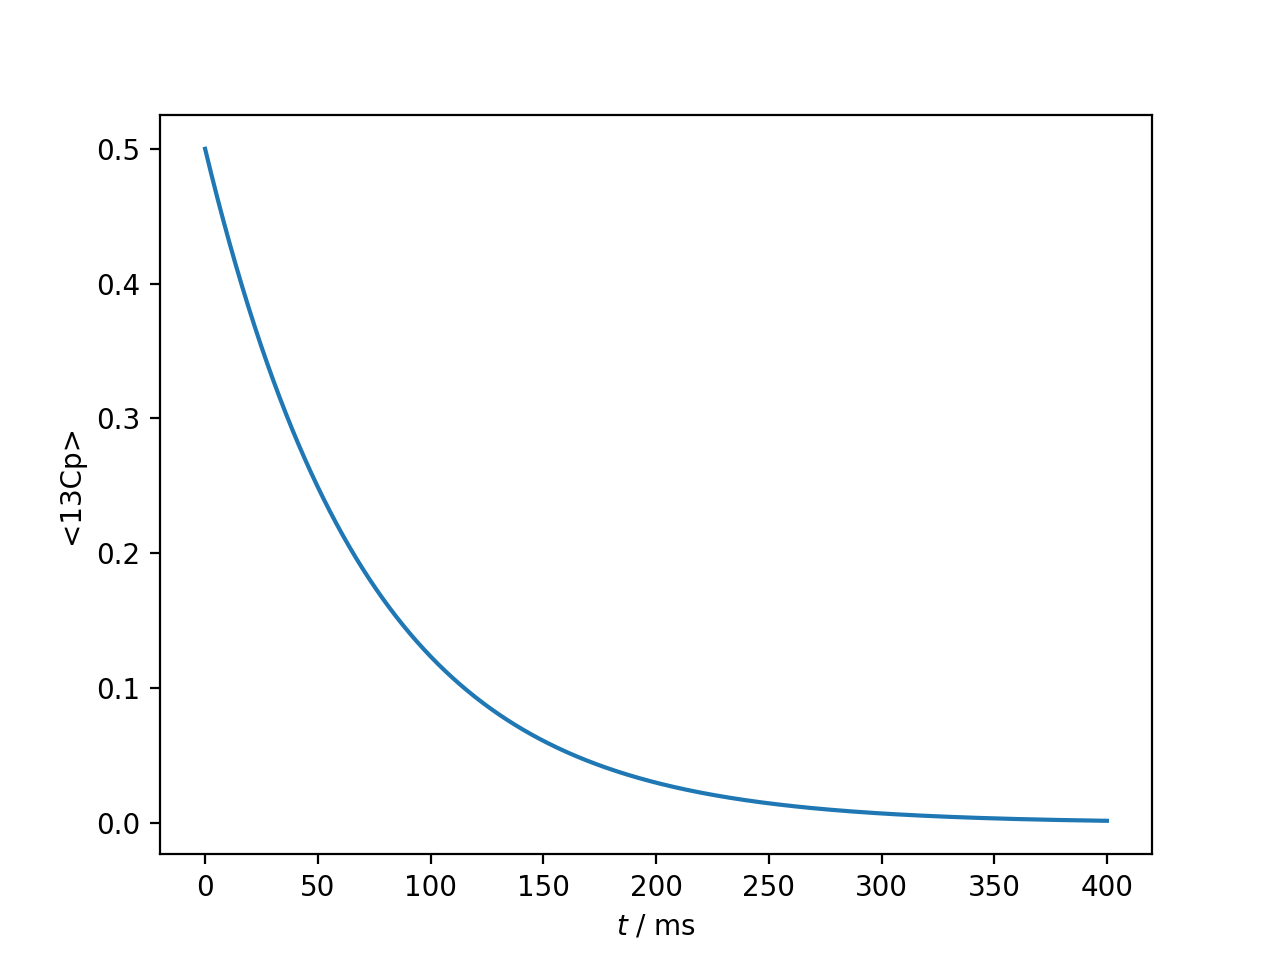

<AxesSubplot:xlabel='$t$ / ms', ylabel='<13Cp>'>

In [25]:
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(1e-9)
U=L.U(Dt=.1)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
rho.plot()

<IPython.core.display.Javascript object>


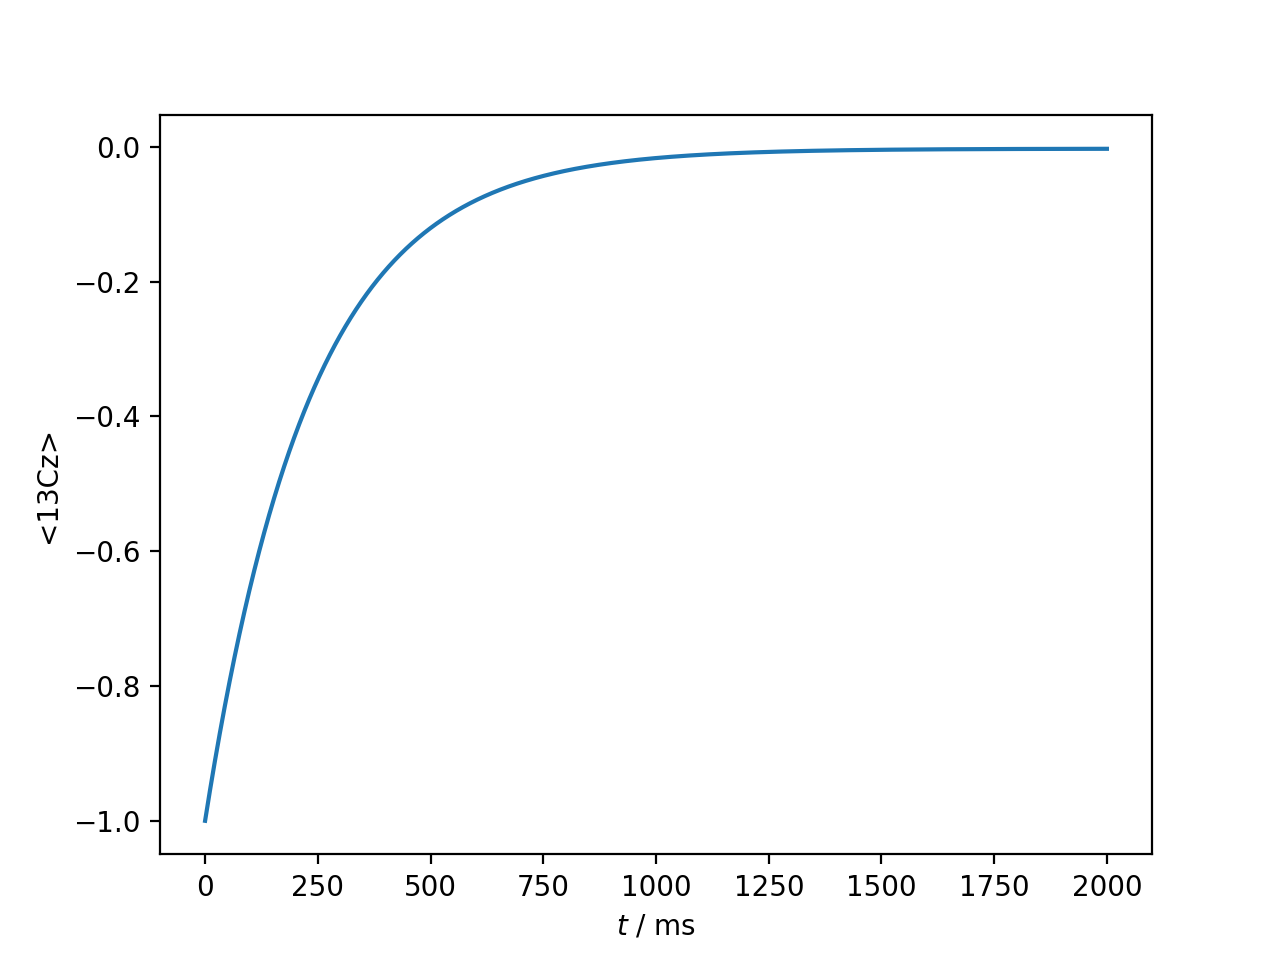

<AxesSubplot:xlabel='$t$ / ms', ylabel='<13Cz>'>

In [30]:
rho=RS.Rho(rho0='-13Cz',detect='13Cz')
rho.DetProp(U,n=20000)
rho.plot()

<IPython.core.display.Javascript object>


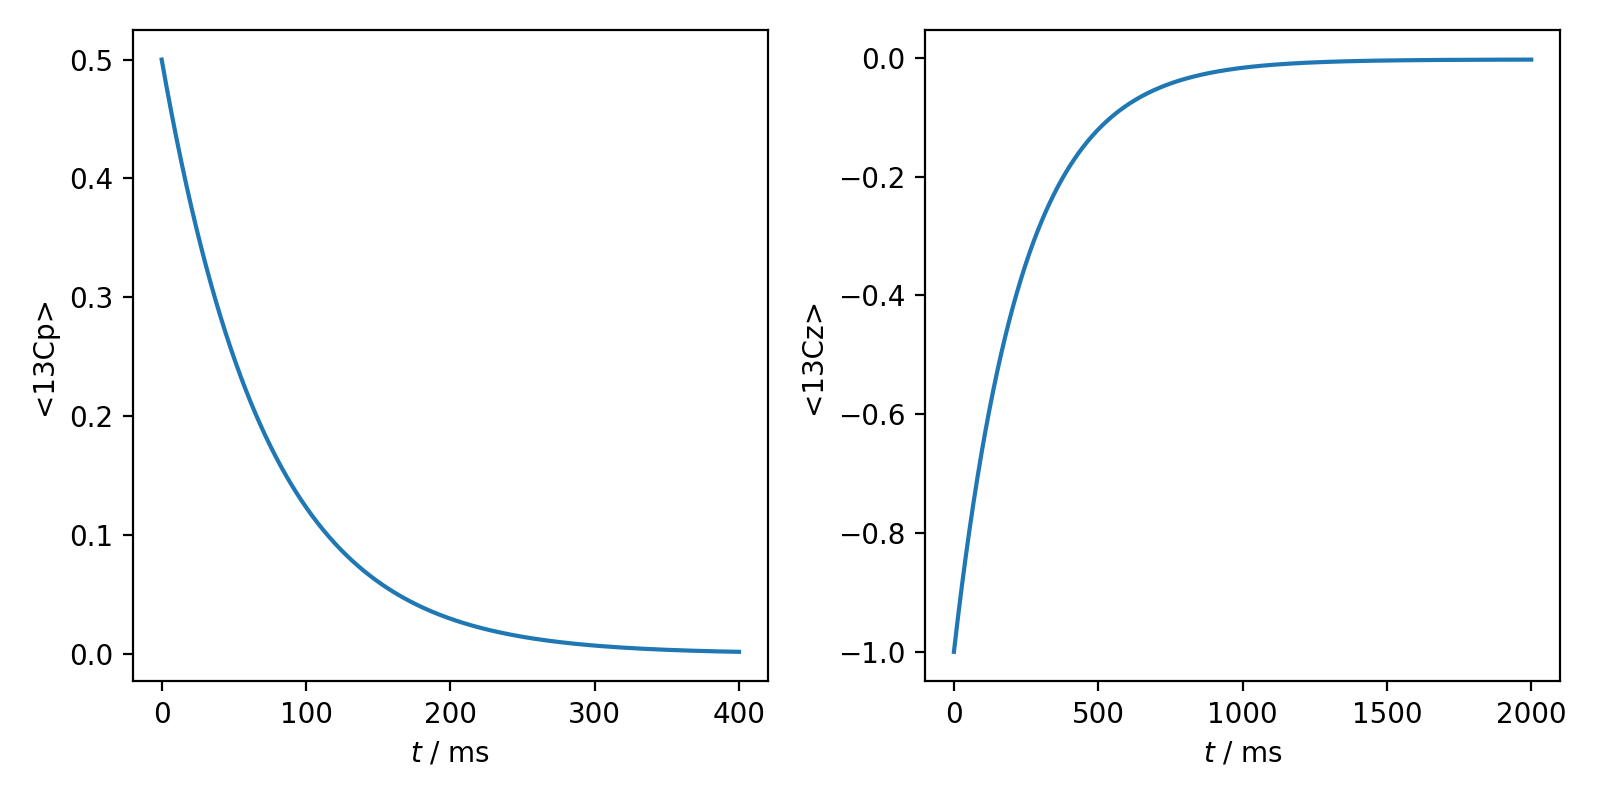

In [37]:
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='T1',i=1,T1=1e-10)
fig,ax=plt.subplots(1,2)
fig.set_size_inches(8,4)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
rho.plot(ax=ax[0])

rho=RS.Rho(rho0='-13Cz',detect='13Cz')
rho.DetProp(U,n=20000)
rho.plot(ax=ax[1])
fig.tight_layout()